# Obiettivo

Rivestono particolare importanza, per la loro vulnerabilità, quelli appartenenti al tema p0106, cioè p0106011_scuole, p0106021, stadi, p0106031_strutturesanitarie, ecc., oltre a p0104031_prontosoccorso (che costituisce una classe particolare di p0106031_strutturesanitarie censita separatamente, in quanto anche con funzione strategica).

Trasferire questa informazione agli edifici di OVERTURE, per non dover lavorare con geometrie diverse, ossia individuare il corrispondente edificio in OVERTURE che è stato indicato come p0106011_scuole, p0106021, stadi, p0106031_strutturesanitarie, ecc. nei piani comunali di protezione civile.

## Esempio overlap

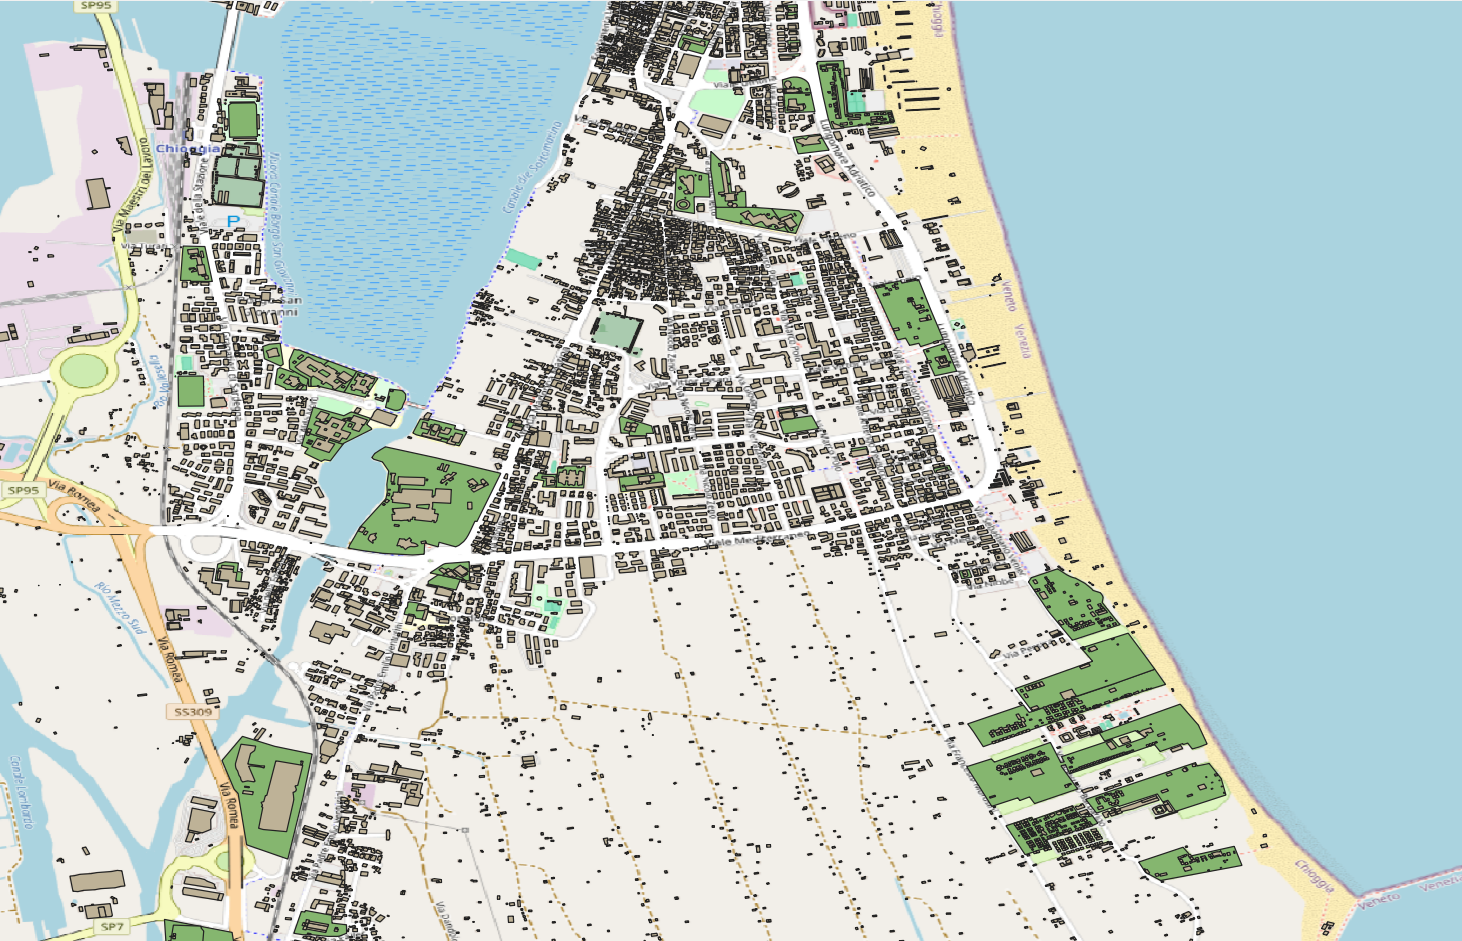

# Deps

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, MultiPolygon
from shapely.strtree import STRtree

# REF: https://github.com/SaferPlaces2023/safer-buildings → `pip install git+https://github.com/SaferPlaces2023/safer-buildings.git#egg=safer-buildings[with_gdal_py3**]`
from safer_buildings import _consts, _utils
from safer_buildings import filesystem
from safer_buildings import module_retriever

import importlib
_ = importlib.reload(_consts)
_ = importlib.reload(_utils)

# Venezia WFS Layers

In [2]:
_consts.init_venezia_wfs_layers()
_consts.VeneziaLayers

,Name,Title,DefaultSRS,Operations,ows:WGS84BoundingBox,provider_name
0,c0107057_grafostrade,c0107057_grafostrade,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.94...",VENEZIA-WFS/c0107057_grafostrade
1,c0107087_ponti,c0107087_ponti,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.97...",VENEZIA-WFS/c0107087_ponti
2,c0107097_gallerie,c0107097_gallerie,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '12.05...",VENEZIA-WFS/c0107097_gallerie
3,mv_risorse_p0109033_materiali,p0109033_materiali,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '12.00...",VENEZIA-WFS/mv_risorse_p0109033_materiali
4,mv_risorse_p0109043_natanti,p0109043_natanti,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '12.04...",VENEZIA-WFS/mv_risorse_p0109043_natanti
...,...,...,...,...,...,...
81,v_pc_p0201121_crollodighe,p0201121_crollodighe,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '0 0',...",VENEZIA-WFS/v_pc_p0201121_crollodighe
82,v_pc_p0201131_idropotabile,p0201131_idropotabile,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.95...",VENEZIA-WFS/v_pc_p0201131_idropotabile
83,v_pc_p0202013_idranti,p0202013_idranti,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.93...",VENEZIA-WFS/v_pc_p0202013_idranti
84,v_pc_p0202022_stradeforestali,p0202022_stradeforestali,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '12.28...",VENEZIA-WFS/v_pc_p0202022_stradeforestali


In [3]:
interset_layers_titles = [title for title in _consts.VeneziaLayers.Title if title.startswith('p0106') or title=='p0104031_prontosoccorso']
interset_layers = _consts.VeneziaLayers[_consts.VeneziaLayers.Title.isin(interset_layers_titles)]
interset_layers

,Name,Title,DefaultSRS,Operations,ows:WGS84BoundingBox,provider_name
25,v_pc_p0104031_prontosoccorso,p0104031_prontosoccorso,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '12.05...",VENEZIA-WFS/v_pc_p0104031_prontosoccorso
41,v_pc_p0106011_scuole,p0106011_scuole,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.96...",VENEZIA-WFS/v_pc_p0106011_scuole
42,v_pc_p0106021_stadi,p0106021_stadi,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.96...",VENEZIA-WFS/v_pc_p0106021_stadi
43,v_pc_p0106031_strutturesanitarie,p0106031_strutturesanitarie,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.99...",VENEZIA-WFS/v_pc_p0106031_strutturesanitarie
44,v_pc_p0106041_casecura,p0106041_casecura,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.98...",VENEZIA-WFS/v_pc_p0106041_casecura
45,v_pc_p0106051_edificirilevantigenerici,p0106051_edificirilevantigenerici,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.99...",VENEZIA-WFS/v_pc_p0106051_edificirilevantigene...
46,v_pc_p0106061_centricommerciali,p0106061_centricommerciali,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.97...",VENEZIA-WFS/v_pc_p0106061_centricommerciali
47,v_pc_p0106071_museibiblioteche,p0106071_museibiblioteche,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.99...",VENEZIA-WFS/v_pc_p0106071_museibiblioteche
48,v_pc_p0106081_salespettacoli,p0106081_salespettacoli,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '12.01...",VENEZIA-WFS/v_pc_p0106081_salespettacoli
49,v_pc_p0106091_banchept,p0106091_banchept,EPSG:3003,{'Operation': 'Query'},"{'@dimensions': '2', 'ows:LowerCorner': '11.97...",VENEZIA-WFS/v_pc_p0106091_banchept


# Bacino 1

In [4]:
# bld_ovt = gpd.read_file('building_datasets/building_1.shp').reset_index(drop=True)
# bld_ovt['index'] = bld_ovt.index
# bld_ovt.to_file('building_datasets/building_1.shp')
bld_ovt = gpd.read_file('building_datasets/building_1.gpkg').sort_values(by='index').reset_index(drop=True)
bld_ovt

,id,height,subtype,class,is_undergr,value_m2,fdamage,__locked__,index,merge_type,wfs_service_id,geometry
0,f14d55b6-6a4a-4288-a6b3-8b3462630652,NaN,outbuilding,shed,False,1000,fdamage/shared/JRC/Europe/industrial,0,0,ovt_original,None,"MULTIPOLYGON (((258852.583 4987361.868, 258849..."
1,74aa10c4-4c15-4e3a-bd68-8ea4aa907b19,NaN,outbuilding,shed,False,1000,fdamage/shared/JRC/Europe/industrial,0,1,ovt_original,None,"MULTIPOLYGON (((258868.454 4987377.076, 258864..."
2,3c4c1aab-9532-4f68-9baa-5904649c7f2b,NaN,None,None,False,1000,fdamage/shared/JRC/Europe/residential,0,2,ovt_original,None,"MULTIPOLYGON (((258872.005 4987371.836, 258868..."
3,e2ad8350-3b63-491d-8032-5ccfc7649270,NaN,None,None,False,1000,fdamage/shared/JRC/Europe/residential,0,3,ovt_original,None,"MULTIPOLYGON (((258844.851 4987410.608, 258845..."
4,b996b648-e506-4be5-86bc-aa3f5b9a4254,NaN,outbuilding,shed,False,1000,fdamage/shared/JRC/Europe/industrial,0,4,ovt_original,None,"MULTIPOLYGON (((259328.464 4986874.055, 259327..."
...,...,...,...,...,...,...,...,...,...,...,...,...
110542,0e7ca704-f088-4ece-88ed-b1452469267e,19.803530,None,None,False,1000,fdamage/shared/JRC/Europe/residential,0,110542,ovt_original,None,"MULTIPOLYGON (((289527.224 5021220.715, 289532..."
110543,a6bd10af-4a73-4e6a-8d0d-9b8dd4412756,NaN,None,None,False,1000,fdamage/shared/JRC/Europe/residential,0,110543,ovt_original,None,"MULTIPOLYGON (((289533.322 5021221.212, 289534..."
110544,affb5e05-03ea-4380-9b09-ee6361e269b6,NaN,None,None,False,1000,fdamage/shared/JRC/Europe/residential,0,110544,ovt_original,None,"MULTIPOLYGON (((289510.029 5021231.02, 289507...."
110545,bdd5cb3f-2251-45bb-b64c-a90bdf2c0b27,2.377109,residential,hut,False,1000,fdamage/shared/JRC/Europe/residential,0,110545,ovt_original,None,"MULTIPOLYGON (((289354.397 5021268.653, 289356..."


In [5]:
# bld_ovt.to_file('building_datasets/building_1.gpkg', driver=filesystem._GPD_DRIVERS('gpkg'))

In [6]:
# bld_wfs =module_retriever.retrieve_venezia_wfs(
#     provider = f"{_consts._VENEZIA_WFS_PROVIDER}/{'/'.join(interset_layers.Name)}",
#     bbox=gpd.GeoDataFrame({'geometry':[box(*bld_ovt.total_bounds)]}, crs=bld_ovt.crs),
#     buffer_points = False
# ).reset_index(drop=True)
# bld_wfs['index'] = bld_wfs.index
# bld_wfs.to_crs(utm_epsg).to_file('building_datasets/venezia_wfs_1.gpkg', driver=filesystem._GPD_DRIVERS('gpkg'), index=False)
bld_wfs = gpd.read_file('building_datasets/venezia_wfs_1.gpkg').sort_values(by='index').reset_index(drop=True)
display(bld_wfs)
bld_wfs.geometry.apply(lambda g: g.geom_type).value_counts()

,agg,asl,aut_acqua,aut_gas,aut_gener,codistat,degenti,denom,_fid,generat_t,...,u_specif,persone,operai,s_altro,segnale_t,t_specif,stanze,superficie,index,geometry
0,2019-05-16,503.0,300000.0,NaN,50.0,27008,141.0,Ospedale di Chioggia,3657,Sì,...,None,NaN,NaN,None,None,None,NaN,NaN,0,"MULTIPOLYGON (((286788.438 5008693.125, 286727..."
1,2012-11-20,NaN,NaN,NaN,NaN,27010,NaN,"Scuola dell'infanzia (par.) ""S. Giovanni Bosco""",186803,None,...,None,NaN,NaN,None,None,None,NaN,NaN,1,"MULTIPOLYGON (((267266.84 5008543.503, 267299...."
2,2012-11-20,NaN,NaN,NaN,NaN,27010,NaN,"Scuola primaria (st.) ""G. D'Annunzio""",186804,None,...,None,NaN,NaN,None,None,None,NaN,NaN,2,"MULTIPOLYGON (((267525.643 5008368.258, 267563..."
3,NaT,NaN,NaN,NaN,NaN,27010,NaN,Scuola elementare di Cantarana,186805,None,...,None,NaN,NaN,None,None,None,NaN,NaN,3,"MULTIPOLYGON (((272273.63 5009252.95, 272296.1..."
4,2012-11-20,NaN,NaN,NaN,NaN,27010,NaN,"Scuola secondaria di I° (st.) ""Tito Livio""",186806,None,...,None,NaN,NaN,None,None,None,NaN,NaN,4,"MULTIPOLYGON (((267495.035 5008425.891, 267516..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2014-05-14,NaN,NaN,NaN,NaN,27042,NaN,Santo Stefano Protomartire,130482,None,...,None,NaN,NaN,None,None,None,NaN,NaN,301,"MULTIPOLYGON (((289150.762 5020871.515, 289169..."
302,2014-05-14,NaN,NaN,NaN,NaN,27042,NaN,Sant'Antonio,130483,None,...,None,NaN,NaN,None,None,None,NaN,NaN,302,"MULTIPOLYGON (((288426.404 5017904.355, 288428..."
303,2014-05-14,NaN,NaN,NaN,NaN,27042,NaN,Madonna dell’apparizione e Santi Vito e Modesto,130484,None,...,None,NaN,NaN,None,None,None,NaN,NaN,303,"MULTIPOLYGON (((288294.674 5016756.232, 288300..."
304,2014-05-14,NaN,NaN,NaN,NaN,27042,NaN,Ognissanti,130485,None,...,None,NaN,NaN,None,None,None,NaN,NaN,304,"MULTIPOLYGON (((288280.439 5016012.228, 288281..."


geometry
MultiPolygon    306
Name: count, dtype: int64

In [7]:
# bld_wfs.to_file('building_datasets/venezia_wfs_1.gpkg', driver=filesystem._GPD_DRIVERS('gpkg'))

# Prepare for intersection

In [8]:
# utm_epsg = _utils.epsg_from_coords(*bld_ovt.total_bounds.reshape((2,2)).mean(axis=0))

# bld_ovt['geometry'] = bld_ovt.geometry.to_crs(utm_epsg)
# bld_wfs['geometry'] = bld_wfs.geometry.to_crs(utm_epsg).buffer(_consts._RING_BUFFER_M).to_crs(bld_wfs.geometry.crs)
# bld_wfs['geometry'] = bld_wfs.geometry.to_crs(utm_epsg)

bld_wfs_tree = STRtree(bld_wfs.geometry)

In [9]:
ovt_into_wfs_query = pd.DataFrame(
    bld_wfs_tree.query(bld_ovt.geometry, predicate='within').T,
    columns=['ovt_idxs', 'wfs_idxs']
)
ovt_inter_wfs_query = pd.DataFrame(
    bld_wfs_tree.query(bld_ovt.geometry, predicate='intersects').T,
    columns=['ovt_idxs', 'wfs_idxs']
)
ovt_inter_wfs_query = ovt_inter_wfs_query[~ovt_inter_wfs_query.ovt_idxs.isin(ovt_into_wfs_query.ovt_idxs)].reset_index(drop=True)

In [10]:
bld_ovt['merge_type'] = 'ovt_original'
bld_ovt['wfs_idx'] = None

## OVT inside WFS

Se l'edficio overture è completamente interno a edifico wfs allora l'edificio overture prende gli attributi suoi

In [11]:
bld_ovt['wfs_service_id'] = None
bld_ovt.loc[ovt_into_wfs_query['ovt_idxs'], 'wfs_service_id'] = pd.Series(
    bld_wfs.loc[ovt_into_wfs_query['wfs_idxs'], 'service_id'].values,
    index=ovt_into_wfs_query['ovt_idxs']
)
bld_ovt.loc[ovt_into_wfs_query['ovt_idxs'], 'merge_type'] = 'ovt_inside_wfs'
bld_ovt.loc[ovt_into_wfs_query['ovt_idxs'], 'wfs_idx'] = pd.Series(ovt_into_wfs_query['wfs_idxs'].values, index=ovt_into_wfs_query['ovt_idxs'])

## OVT intersects WFS

In [12]:
print(f'total intersecting OVT buildings: {len(ovt_inter_wfs_query)}')

total intersecting OVT buildings: 623


<Axes: >

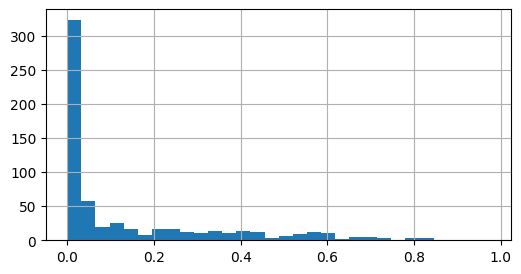

In [13]:
ovt_inter_wfs_query['iou_area'] = ovt_inter_wfs_query.apply(
    lambda row: (bld_ovt.loc[row.ovt_idxs].geometry.intersection(bld_wfs.loc[row.wfs_idxs].geometry).area) / (bld_ovt.loc[row.ovt_idxs].geometry.union(bld_wfs.loc[row.wfs_idxs].geometry).area),
    axis=1
)
plt.figure(figsize=(6, 3))
ovt_inter_wfs_query['iou_area'].hist(bins=30)

### If IoU >= thresh (0.3)

In [14]:
above_iou = ovt_inter_wfs_query['iou_area'] >= 0.3
bld_ovt.loc[
    ovt_inter_wfs_query[above_iou].ovt_idxs,
    'wfs_service_id'
] = pd.Series(
    bld_wfs.loc[ovt_inter_wfs_query[above_iou].wfs_idxs, 'service_id'].values,
    index=ovt_inter_wfs_query[above_iou].ovt_idxs
)
bld_ovt.loc[ovt_inter_wfs_query[above_iou].ovt_idxs, 'merge_type'] = 'ovt_iou_wfs'
bld_ovt.loc[ovt_inter_wfs_query[above_iou].ovt_idxs, 'wfs_idx'] = pd.Series(ovt_inter_wfs_query[above_iou]['wfs_idxs'].values, index=ovt_inter_wfs_query[above_iou]['ovt_idxs'])

In [15]:
above_iou.sum()

125

### Else-If IoU < 0.4

#### OVT almost in WFS

In [16]:
below_iou = ~above_iou
ovt_inter_wfs_query = ovt_inter_wfs_query[below_iou]
ovt_inter_wfs_query

,ovt_idxs,wfs_idxs,iou_area
1,21343,271,0.095165
2,21344,271,0.040888
3,21353,60,0.013324
4,22553,273,0.000487
5,22554,273,0.002647
...,...,...,...
616,110259,223,0.000791
617,110260,223,0.000759
618,110262,223,0.000796
619,110263,223,0.002406


<Axes: >

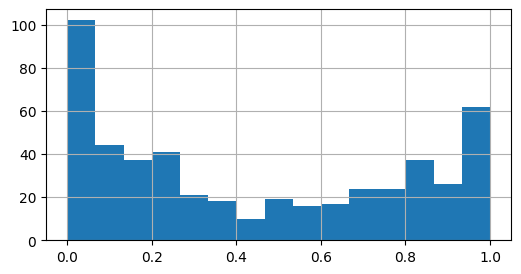

In [17]:
ovt_inter_wfs_query['ovt_in_area'] = ovt_inter_wfs_query.apply(
    lambda row: (bld_ovt.loc[row.ovt_idxs].geometry.intersection(bld_wfs.loc[row.wfs_idxs].geometry).area) / (bld_ovt.loc[row.ovt_idxs].geometry.area),
    axis=1
)
plt.figure(figsize=(6, 3))
ovt_inter_wfs_query['ovt_in_area'].hist(bins=15)

In [18]:
ovt_in_thresh = 0.6

In [19]:
above_ovt_in = ovt_inter_wfs_query[ovt_inter_wfs_query['ovt_in_area'] > ovt_in_thresh].sort_values('ovt_in_area', ascending=False).drop_duplicates('ovt_idxs', keep='first')
above_ovt_in = ovt_inter_wfs_query.index.isin(above_ovt_in.index)
bld_ovt.loc[
    ovt_inter_wfs_query[above_ovt_in].ovt_idxs,
    'wfs_service_id'
] = pd.Series(
    bld_wfs.loc[ovt_inter_wfs_query[above_ovt_in].wfs_idxs, 'service_id'].values,
    index=ovt_inter_wfs_query[above_ovt_in].ovt_idxs
)
bld_ovt.loc[ovt_inter_wfs_query[above_ovt_in].ovt_idxs, 'merge_type'] = 'ovt_almost-in_wfs'
bld_ovt.loc[ovt_inter_wfs_query[above_ovt_in].ovt_idxs, 'wfs_idx'] = pd.Series(ovt_inter_wfs_query[above_ovt_in]['wfs_idxs'].values, index=ovt_inter_wfs_query[above_ovt_in]['ovt_idxs'])

In [20]:
above_ovt_in.sum()

190

#### WFS almost in OVT

In [21]:
below_ovt_in = ~above_ovt_in
ovt_inter_wfs_query = ovt_inter_wfs_query[below_ovt_in]
ovt_inter_wfs_query

,ovt_idxs,wfs_idxs,iou_area,ovt_in_area
3,21353,60,0.013324,0.242664
4,22553,273,0.000487,0.079390
6,23540,183,0.000008,0.018910
8,23693,183,0.000078,0.182101
9,23695,183,0.000115,0.142251
...,...,...,...,...
605,109874,222,0.000696,0.399363
608,109877,222,0.001596,0.539981
611,110063,252,0.000002,0.000093
617,110260,223,0.000759,0.595943


<Axes: >

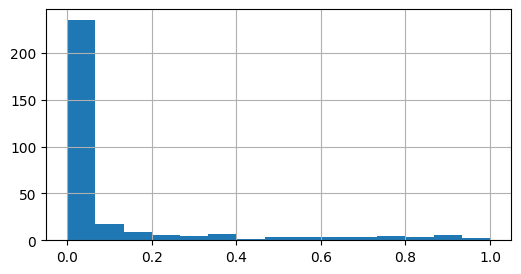

In [22]:
ovt_inter_wfs_query['wfs_in_area'] = ovt_inter_wfs_query.apply(
    lambda row: (bld_ovt.loc[row.ovt_idxs].geometry.intersection(bld_wfs.loc[row.wfs_idxs].geometry).area) / (bld_wfs.loc[row.wfs_idxs].geometry.area),
    axis=1
)
plt.figure(figsize=(6, 3))
ovt_inter_wfs_query['wfs_in_area'].hist(bins=15)

In [23]:
wfs_in_thresh = 0.6

In [24]:
above_wfs_in = ovt_inter_wfs_query[ovt_inter_wfs_query['wfs_in_area'] > wfs_in_thresh].sort_values('wfs_in_area', ascending=False).drop_duplicates('wfs_idxs', keep='first')
above_wfs_in = ovt_inter_wfs_query.index.isin(above_wfs_in.index)
above_wfs_in.sum()

22

In [25]:
ovt_diff_wfs = ovt_inter_wfs_query[above_wfs_in].groupby(by='ovt_idxs').agg({'wfs_idxs': list}).reset_index().apply(
    lambda row: (row.ovt_idxs, bld_ovt.loc[row.ovt_idxs].geometry.difference(bld_wfs.loc[row.wfs_idxs].geometry.union_all()).simplify(0.001, preserve_topology=True)),
    axis=1
).values

ovt_crop_idx = [ovt_diff[0] for ovt_diff in ovt_diff_wfs]
ovt_crop_geom = [ovt_diff[1] for ovt_diff in ovt_diff_wfs]

bld_ovt.loc[ovt_crop_idx, 'geometry'] = gpd.GeoSeries(ovt_crop_geom, index=ovt_crop_idx, crs=bld_ovt.crs)
bld_ovt.loc[ovt_crop_idx, 'merge_type'] = 'ovt_crop_wfs'
bld_ovt.loc[ovt_inter_wfs_query[above_wfs_in].ovt_idxs, 'wfs_idx'] = pd.Series(ovt_inter_wfs_query[above_wfs_in]['wfs_idxs'].values, index=ovt_inter_wfs_query[above_wfs_in]['ovt_idxs'])

len_bld_ovt = len(bld_ovt)
bld_ovt = pd.concat([
    bld_ovt,
    bld_wfs.loc[ovt_inter_wfs_query[above_wfs_in].wfs_idxs].rename(columns = {'service_id': 'wfs_service_id'})
]).reset_index(drop=True)
bld_ovt.loc[len_bld_ovt:, 'merge_type'] = 'wfs_almost-in_ovt'
bld_ovt.loc[len_bld_ovt:, 'wfs_idx'] = pd.Series(ovt_inter_wfs_query[above_wfs_in]['wfs_idxs'].values, index=range(len_bld_ovt, len(bld_ovt)))
bld_ovt.loc[len_bld_ovt:, 'index'] = pd.Series(list(range(len_bld_ovt, len(bld_ovt))), index=range(len_bld_ovt, len(bld_ovt)))

#### Almost separate

In [26]:
below_wfs_in = ~above_wfs_in
ovt_inter_wfs_query = ovt_inter_wfs_query[below_wfs_in]
ovt_inter_wfs_query

,ovt_idxs,wfs_idxs,iou_area,ovt_in_area,wfs_in_area
3,21353,60,0.013324,0.242664,0.013902
4,22553,273,0.000487,0.079390,0.000490
6,23540,183,0.000008,0.018910,0.000008
8,23693,183,0.000078,0.182101,0.000078
9,23695,183,0.000115,0.142251,0.000115
...,...,...,...,...,...
605,109874,222,0.000696,0.399363,0.000696
608,109877,222,0.001596,0.539981,0.001598
611,110063,252,0.000002,0.000093,0.000002
617,110260,223,0.000759,0.595943,0.000759


In [27]:
bld_wfs.loc[ovt_inter_wfs_query.drop_duplicates(subset='wfs_idxs').drop_duplicates(subset='ovt_idxs').wfs_idxs].to_file('no-merged_wfs.gpkg', driver=filesystem._GPD_DRIVERS('gpkg'))

# Disjointed

In [28]:
bld_ovt_tree = STRtree(bld_ovt.geometry)

wfs_out_ovt = bld_wfs.loc[~bld_wfs.index.isin(pd.Series(bld_ovt_tree.query(bld_wfs.geometry, predicate='intersects')[0,:]))]
wfs_out_ovt

,agg,asl,aut_acqua,aut_gas,aut_gener,codistat,degenti,denom,_fid,generat_t,...,u_specif,persone,operai,s_altro,segnale_t,t_specif,stanze,superficie,index,geometry
55,2021-02-08,NaN,NaN,NaN,NaN,27042,NaN,San Pietro in Volta asilo nido,187321,None,...,None,NaN,NaN,None,None,None,NaN,NaN,55,"MULTIPOLYGON (((289698.461 5021889.441, 289681..."
56,2021-02-08,NaN,NaN,NaN,NaN,27042,NaN,San Pietro in Volta scuola dell'infanzia,187322,None,...,None,NaN,NaN,None,None,None,NaN,NaN,56,"MULTIPOLYGON (((289698.461 5021889.441, 289688..."
65,NaT,NaN,NaN,NaN,NaN,27010,NaN,Campo sportivo di Foresto,114189,None,...,None,NaN,NaN,None,None,None,NaN,NaN,65,"MULTIPOLYGON (((268703.046 5008311.39, 268814...."
67,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,Campo sportivo Chiesa Madonna della Navicella,114169,None,...,None,NaN,NaN,None,None,None,NaN,NaN,67,"MULTIPOLYGON (((286674.471 5008320.715, 286662..."
69,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,Campo da calcio di Ca' Lino,114171,None,...,None,NaN,NaN,None,None,None,NaN,NaN,69,"MULTIPOLYGON (((287807.542 5004388.836, 287878..."
70,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,Campo sportivo Borgo S. Giovanni,114172,None,...,None,NaN,NaN,None,None,None,NaN,NaN,70,"MULTIPOLYGON (((285991.633 5009064.311, 286055..."
73,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,SANT'ANNA,114175,None,...,None,NaN,NaN,None,None,None,NaN,NaN,73,"MULTIPOLYGON (((285066.969 5002065.767, 285130..."
81,2015-12-02,NaN,NaN,NaN,NaN,27042,NaN,Centro Sportivo Corrado Ballarin,114526,None,...,None,NaN,NaN,None,None,None,NaN,NaN,81,"MULTIPOLYGON (((289249.226 5020678.047, 289290..."
132,2015-12-16,NaN,NaN,NaN,NaN,27042,NaN,Biblioteca Cagnaccio di San Pietro,44600,None,...,None,0.0,NaN,None,None,None,NaN,NaN,132,"MULTIPOLYGON (((289624.374 5021818.286, 289638..."
176,2015-12-14,NaN,NaN,NaN,NaN,27042,NaN,Ufficio Postale SAN PIETRO IN VOLTA,106751,None,...,None,NaN,NaN,None,None,None,NaN,NaN,176,"MULTIPOLYGON (((289702.733 5021895.193, 289697..."


In [29]:
# Then add records of the almost-in-WFS-buildings to the OVT buildings
len_bld_ovt = len(bld_ovt)
bld_ovt = pd.concat([
    bld_ovt,
    wfs_out_ovt.rename(columns = {'service_id': 'wfs_service_id'})
]).reset_index(drop=True)
bld_ovt.loc[len_bld_ovt:, 'merge_type'] = 'wfs_outside_ovt'
bld_ovt.loc[len_bld_ovt:, 'wfs_idx'] = pd.Series(wfs_out_ovt['index'].values, index=range(len_bld_ovt, len(bld_ovt)))
bld_ovt.loc[len_bld_ovt:, 'index'] = pd.Series(list(range(len_bld_ovt, len(bld_ovt))), index=range(len_bld_ovt, len(bld_ovt)))

In [30]:
# bld_ovt.to_file('bacino_1_ovt_wfs.gpkg', driver=filesystem._GPD_DRIVERS('gpkg'), index=False)

# Full merge

In [ ]:
# bld_ovt = gpd.read_file('bacino_1_ovt_wfs.gpkg').sort_values(by='index').reset_index(drop=True)

bld_ovt.loc[bld_ovt.wfs_idx.isnull(), 'wfs_idx'] = -1
bld_ovt.wfs_idx = bld_ovt.wfs_idx.apply(lambda x: int(x) if isinstance(x, str) else x)

bld_merged = pd.merge(
    bld_ovt, wfs_out_ovt.rename(columns = {'service_id': 'wfs_service_id'}),
    left_on='wfs_idx', right_index=True,
    how='left'
)

In [ ]:
print(f'N. edifici wfs mergiati: {(bld_merged.wfs_idx.unique()).shape[0]}')
print(f'N. edifici wfs non mergiati: {wfs_not_merged.shape[0]} ↓↓↓')

display(wfs_not_merged)

N. edifici wfs mergiati: 280
N. edifici wfs non mergiati: 27 ↓↓↓


,agg,asl,aut_acqua,aut_gas,aut_gener,codistat,degenti,denom,_fid,generat_t,...,u_specif,persone,operai,s_altro,segnale_t,t_specif,stanze,superficie,index,geometry
26,2019-09-16,NaN,NaN,NaN,NaN,27008,NaN,B.MADERNA,186776,None,...,None,NaN,NaN,None,None,None,NaN,NaN,26,"MULTIPOLYGON (((285119.388 5002914.58, 285144...."
52,2025-02-12,NaN,NaN,NaN,NaN,27042,NaN,B. Zendrini scuola dell'infanzia,187174,None,...,None,NaN,NaN,None,None,None,NaN,NaN,52,"MULTIPOLYGON (((288368.537 5017109.428, 288368..."
60,2020-06-11,NaN,0.0,0.0,0.0,27006,NaN,Campo sportivo di Rottanova,114164,No,...,None,NaN,NaN,None,None,None,NaN,NaN,60,"MULTIPOLYGON (((265254.178 5003077.544, 265254..."
72,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,"Stadio comunale ""Ballarin""",114174,None,...,None,NaN,NaN,None,None,None,NaN,NaN,72,"MULTIPOLYGON (((286150.406 5010020.09, 286159...."
74,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,Palazzetto dello Sport di Valli,114176,None,...,None,NaN,NaN,None,None,None,NaN,NaN,74,"MULTIPOLYGON (((279442.741 5011662.763, 279450..."
75,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,CAMPO CALCIO CA' BIANCA,114177,None,...,None,NaN,NaN,None,None,None,NaN,NaN,75,"MULTIPOLYGON (((279893.691 5008391.079, 279945..."
78,2019-06-15,NaN,0.0,0.0,0.0,27008,NaN,"Campo sportivo ""Serenella""",114180,None,...,None,NaN,NaN,None,None,None,NaN,NaN,78,"MULTIPOLYGON (((287623.723 5010764.047, 287647..."
91,2020-06-11,14.0,0.0,0.0,0.0,27006,NaN,Rodella Dr. Franco,37049,No,...,None,NaN,NaN,None,None,None,NaN,NaN,91,"MULTIPOLYGON (((270768.369 5002501.98, 270774...."
93,2019-10-04,3.0,0.0,0.0,0.0,27008,0.0,Studio radiologico San Giacomo,37064,None,...,None,NaN,NaN,None,None,None,NaN,NaN,93,"MULTIPOLYGON (((285999.333 5011170.065, 286020..."
94,2019-10-04,3.0,0.0,0.0,0.0,27008,0.0,Studio dentistico dott. Vianello Lucio,37051,None,...,None,NaN,NaN,None,None,None,NaN,NaN,94,"MULTIPOLYGON (((287470.331 5010322.55, 287485...."
